## Augmentarion(CutMix), pure `EfficientNetV2S` train

In [1]:
import os
import pickle

import tensorflow as tf
# import tensorflow_models as tfm

from tensorflow.keras import Sequential
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.data import Dataset
from tensorflow.keras import optimizers
from tensorflow.keras import losses, metrics
from tensorflow.keras import callbacks

2025-07-04 00:24:09.006228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751556249.019892  849932 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751556249.023562  849932 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751556249.036490  849932 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751556249.036506  849932 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751556249.036507  849932 computation_placer.cc:177] computation placer alr

In [2]:
AUTOTUNE = tf.data.AUTOTUNE  # cache and prefetch for augmenting performance
dataset_path = './datasets/'
butterfly_test = Dataset.load(os.path.join(dataset_path, 'butterfly_test')).cache().prefetch(buffer_size=AUTOTUNE)
butterfly_train = Dataset.load(os.path.join(dataset_path, 'butterfly_train')).cache().prefetch(buffer_size=AUTOTUNE)
butterfly_val = Dataset.load(os.path.join(dataset_path, 'butterfly_val'))

I0000 00:00:1751556251.356688  849932 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2b:00.0, compute capability: 8.9


In [3]:
with open('./datasets/class_weights.pkl', 'rb') as f:
    class_weights = {k : v for k, v in enumerate(pickle.load(f))}

with open('./datasets/index_to_label.pkl', 'rb') as f:
    index_to_label = pickle.load(f)
    n_classes = len(set(index_to_label.keys()))

def to_one_hot(x, y):
    y = tf.one_hot(y, n_classes)
    return x, tf.cast(y, tf.float32)

# CutMix & Mixup NEEDS ON-HOT ENCODING!!! -> FOR (NON-SPARSE) CATEGORICAL CROSSENTROPY
butterfly_test = butterfly_test.map(to_one_hot,
                                    num_parallel_calls=AUTOTUNE)
butterfly_train = butterfly_train.map(to_one_hot,
                                      num_parallel_calls=AUTOTUNE)
butterfly_val = butterfly_val.map(to_one_hot,
                                  num_parallel_calls=AUTOTUNE)

In [4]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(
        height_factor=(-.2, .2),
        width_factor=(-.2, .2),
        #fill_mode='nearest',
        interpolation='bilinear',
    ),
    layers.RandomRotation(
        factor=.1,
        #fill_mode='nearest',
        interpolation='bilinear',
    ),
    # https://openaccess.thecvf.com/content_ICCV_2019/papers/Yun_CutMix_Regularization_Strategy_to_Train_Strong_Classifiers_With_Localizable_Features_ICCV_2019_paper.pdf
    layers.CutMix(
        factor=.5, 
        seed=42
    )
  ],
  name = 'data_augmentation'
)

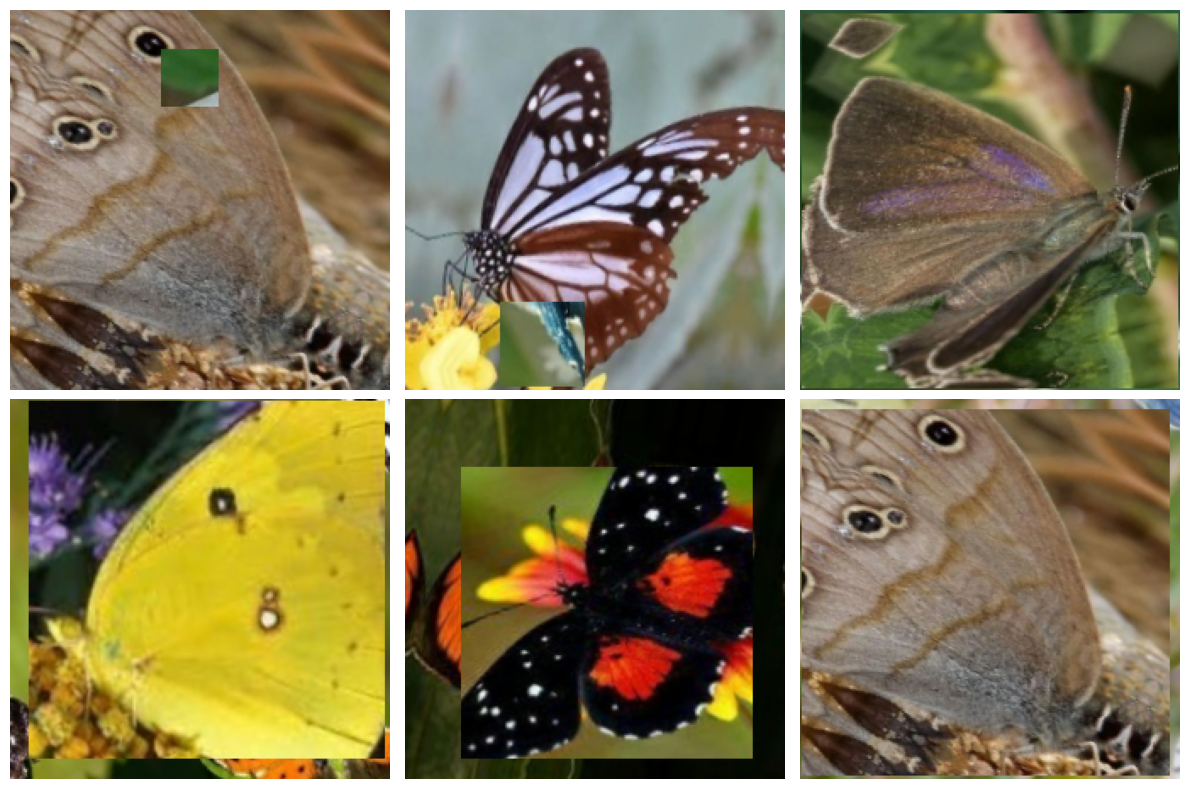

In [25]:
from matplotlib import pyplot as plt
import numpy as np

batch_images, batch_labels = np.array([]), np.array([])

for images, labels in butterfly_train.take(1):  # take(1) as in a single batch (32 images), single loop!
    batch_images = images
    batch_labels = labels

aug_imgs = data_augmentation(batch_images)

plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(aug_imgs[i].numpy().astype("uint8"))
    # plt.title(f"Label: {batch_labels[i].numpy()} - {index_to_label[batch_labels[i].numpy()]}")  # only for integer labeling
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
v2s_base = EfficientNetV2S(
    include_top=False,
    weights='imagenet',  # W, b initialization (FIXED!!!, DO NOT USE RANDOM INIT WHEN FINE TUNING MODELS)
    input_shape=(260, 260, 3),
    pooling='avg',  # 2D tensor output
    include_preprocessing=True,  # inputs to be float tensors of pixels with values in the [0, 255] range to -> [1, -1]
)

v2s_base.trainable = False  # Freeze base model

# =============== MODEL ===============
inp = layers.Input(shape=(224, 224, 3), 
                   name='input')
x = data_augmentation(inp)
x = layers.Resizing(260, 260, 
                    interpolation='bilinear',
                    name='resize')(x)
x = v2s_base(x, training=False)
# x = layers.Dropout(0.25)(x)
out = layers.Dense(75, 
                   activation='softmax', 
                   name='output')(x)
# =============== MODEL ===============

model = Model(inputs=inp, outputs=out, name='EfficientNetV2S_CutMix_augementation')

model.summary()

Model: "EfficientNetV2S_no_augementation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 75)             │        96,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,427,435 (77.92 MB)

 Trainable params: 96,075 (375.29 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [7]:
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
    )
]

# https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
# def scce_with_label_smoothing(y, y_hat):
#     y = tf.one_hot(tf.cast(y, tf.int32), n_classes)
#     return losses.categorical_crossentropy(y, y_hat, label_smoothing = 0.1)

In [8]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=.005),
    loss=losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.1,
    ),
    metrics=['accuracy'],
)

In [9]:
history = model.fit(
    butterfly_train,
    validation_data=butterfly_val,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks_list,
)

Epoch 1/50


I0000 00:00:1751556270.526563  850007 cuda_dnn.cc:529] Loaded cuDNN version 90300


130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.0993 - loss: 4.3006 - val_accuracy: 0.5000 - val_loss: 2.6733 - learning_rate: 0.0050
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.2403 - loss: 3.8112 - val_accuracy: 0.6461 - val_loss: 2.3658 - learning_rate: 0.0050
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.2704 - loss: 3.7738 - val_accuracy: 0.6337 - val_loss: 2.3054 - learning_rate: 0.0050
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.3104 - loss: 3.6766 - val_accuracy: 0.6893 - val_loss: 2.2118 - learning_rate: 0.0050
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.3265 - loss: 3.6307 - val_accuracy: 0.6914 - val_loss: 2.1821 - learning_rate: 0.0050
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.2995 - loss: 3.7422 - val_accuracy: 0.6790 - val_loss: 2.2149 - learning_rate: 0.0050
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.3333 - loss: 3.61

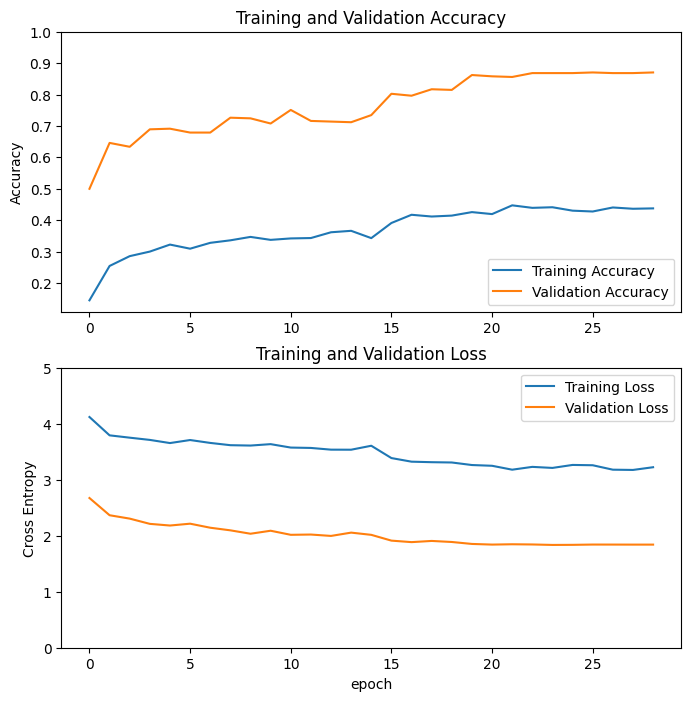

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [11]:
v2s_base.trainable = True
print("Number of layers in the base model: ", len(v2s_base.layers))

Number of layers in the base model:  514


In [12]:
fine_tune_at = 250
for layer in v2s_base.layers[:fine_tune_at]:
  layer.trainable = False

len(model.trainable_variables)

233

In [13]:
# Increase res, Progressive learning
resize = model.get_layer('resize')
resize.target_height = resize.target_width = 260

model.compile(
    optimizer=optimizers.Adam(learning_rate=.0005),
    loss=losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.1,
    ),
    metrics=['accuracy'],
)

model.summary()

Model: "EfficientNetV2S_no_augementation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 75)             │        96,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,427,435 (77.92 MB)

 Trainable params: 16,015,467 (61.09 MB)

 Non-trainable params: 4,411,968 (16.83 MB)

In [14]:
fine_tune_history = model.fit(
    butterfly_train,
    validation_data=butterfly_val,
    epochs=len(history.epoch) + 30,
    initial_epoch=len(history.epoch),
    class_weight=class_weights,
    callbacks=callbacks_list,
)

Epoch 30/59


E0000 00:00:1751556670.627581  849932 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetV2S_no_augementation_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


130/130 ━━━━━━━━━━━━━━━━━━━━ 61s 234ms/step - accuracy: 0.3315 - loss: 3.3695 - val_accuracy: 0.8189 - val_loss: 1.4732 - learning_rate: 5.0000e-04
Epoch 31/59
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.4986 - loss: 2.7449 - val_accuracy: 0.8971 - val_loss: 1.2690 - learning_rate: 5.0000e-04
Epoch 32/59
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.5278 - loss: 2.5486 - val_accuracy: 0.9115 - val_loss: 1.2206 - learning_rate: 5.0000e-04
Epoch 33/59
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.5471 - loss: 2.4698 - val_accuracy: 0.8971 - val_loss: 1.2438 - learning_rate: 5.0000e-04
Epoch 34/59
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5815 - loss: 2.4133
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.5814 - loss: 2.4135 - val_accuracy: 0.8848 - val_loss: 1.3243 - learning_rate: 5.0000e-04
Epoch 35/59
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - 

In [15]:
all_acc = acc + fine_tune_history.history['accuracy']
all_val_acc = val_acc + fine_tune_history.history['val_accuracy']

all_loss = loss + fine_tune_history.history['loss']
all_val_loss = val_loss + fine_tune_history.history['val_loss']

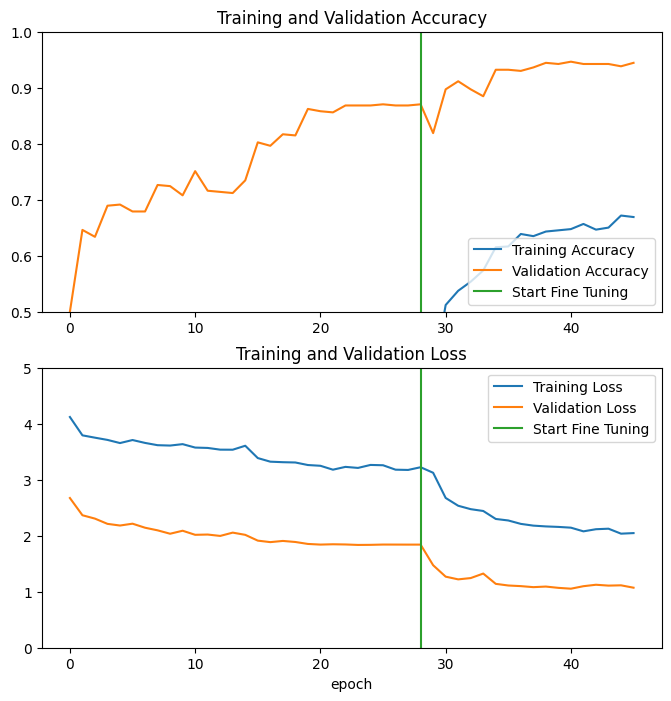

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(all_acc, label='Training Accuracy')
plt.plot(all_val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(all_loss, label='Training Loss')
plt.plot(all_val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [17]:
results = model.evaluate(butterfly_test)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9289 - loss: 1.0678
Test loss: 1.0927820205688477
Test accuracy: 0.9226804375648499
